## WGCNA
https://labs.genetics.ucla.edu/horvath/htdocs/CoexpressionNetwork/Rpackages/WGCNA/

In [34]:
suppressPackageStartupMessages(library(WGCNA))
options(stringsAsFactors = FALSE)

### Data loading

In [2]:
datExpr <- read.csv('data/lipidomics-AUC/expression.csv', row.names = 1)
samples <- rownames(datExpr)
datExpr[, 1:10] # Show first ten genes

,N4875,N1403,N217,N3596,N2659,N112,P2465,N2544,N4280,N5164
WT_1,21.18244,19.36234,26.11922,19.43026,19.11700,28.69853,19.76940,19.88718,19.48701,26.78762
WT_2,17.09327,17.87932,19.14905,17.79795,16.34575,17.15751,17.73000,17.89061,17.86041,23.07029
WT_3,19.63129,20.39710,24.22498,20.24727,18.54379,24.69052,18.50315,19.88501,21.00582,28.84062
WT_4,21.99420,20.77033,24.69169,21.17700,19.46261,21.13714,21.52014,23.03838,23.45073,28.27254
WT_5,20.55441,20.82857,25.20280,21.72499,18.78947,21.61204,20.75303,23.33373,22.86905,28.09655
mdx_6,23.78163,22.97646,22.18410,23.89973,23.06285,18.51657,23.31236,21.58593,22.50658,23.42512
mdx_7,21.45567,20.63608,22.35382,20.77040,19.75733,20.22179,21.27865,18.34389,20.84946,23.67057
mdx_8,21.04961,22.61697,20.61737,21.84282,20.98264,20.06904,22.82674,19.53256,21.12714,22.71395
mdx_9,25.71162,25.52771,22.54127,24.36399,23.07369,19.52946,24.26054,26.12649,24.87205,26.31063
mdx_10,23.05236,23.21690,23.25894,23.20064,22.25877,28.45434,22.34535,18.82294,21.36442,25.56874


### Removing "bad" samples and genes

In [3]:
gsg <- goodSamplesGenes(datExpr, verbose = 0)

print(paste('# samples:', nrow(datExpr)))
print(paste('# bad samples:', sum(!gsg$goodSamples)))

print(paste('# genes:', ncol(datExpr)))
print(paste('# bad genes:', sum(!gsg$goodGenes)))

[1] "# samples: 21"
[1] "# bad samples: 0"
[1] "# genes: 524"
[1] "# bad genes: 0"


The bad samples and genes can be omitted by data-frame filtering. This can also be ran when there are no bad samples and genes. In that case, you're simply rewriting the data-frame with itself.

In [4]:
datExpr <- datExpr[gsg$goodSamples, gsg$goodGenes]
dim(datExpr)

[1]  21 524

### Outlier removal

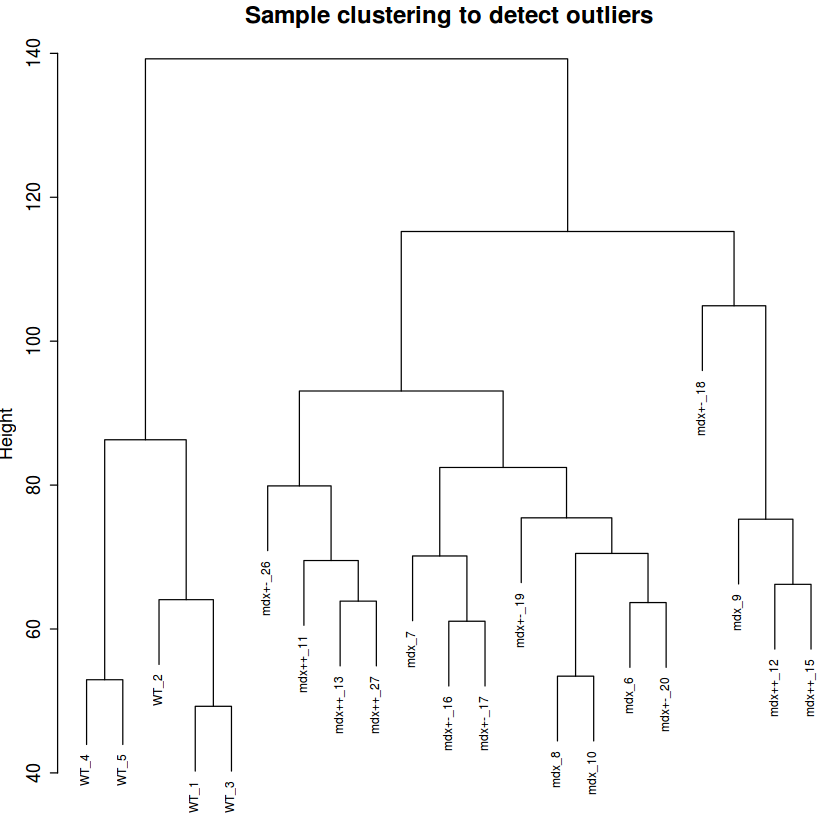

In [5]:
sampleTree <- hclust(dist(datExpr), method = 'average')
par(cex = 0.6, mar = c(0, 4, 2, 0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5,
     cex.axis = 1.5, cex.main = 2)

In case there are outlier samples, you can cut the sample tree at a given height. Setting the cut height to a very high number will leave the tree unchanged.

In [33]:
cutHeight <- 9900
clust <- cutreeStatic(sampleTree, cutHeight = cutHeight, minSize = 10) # Determine cluster under the line
datExpr <- datExpr[clust == 1, ] # clust value == 1 are the samples we want to keep.
dim(datExpr)

[1]  21 524

### Picking a soft-treshold power

In [7]:
powers <- c(c(1:10), seq(from = 12, to=20, by=2))
powers

[1]  1  2  3  4  5  6  7  8  9 10 12 14 16 18 20

In [8]:
sft <- pickSoftThreshold(datExpr, powerVector = powers, verbose = 5,
                         networkType = 'signed', corFnc = 'bicor')

pickSoftThreshold: will use block size 524.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 524 of 524


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.87400  4.9400         0.8950   365.0     380.0  421.0
2      2  0.90600  2.3000         0.8920   270.0     287.0  350.0
3      3  0.91400  1.3800         0.8920   208.0     223.0  297.0
4      4  0.83200  0.8640         0.8020   165.0     177.0  255.0
5      5  0.62000  0.5130         0.5810   134.0     142.0  223.0
6      6  0.16200  0.2150         0.0965   110.0     115.0  198.0
7      7  0.00114  0.0162        -0.0168    92.0      96.0  177.0
8      8  0.05110 -0.1160         0.1380    77.9      80.0  159.0
9      9  0.16300 -0.2290         0.2700    66.6      66.9  144.0
10    10  0.29100 -0.3540         0.4050    57.4      56.4  131.0
11    12  0.47700 -0.5180         0.6110    43.7      41.2  110.0
12    14  0.56700 -0.6240         0.7060    34.2      30.5   94.3
13    16  0.71800 -0.6890         0.8380    27.3      22.9   81.4
14    18  0.80100 -0.7730         0.8810    22.2      17.7   71.1
15    20  

The following code plots the properties of each power as calculated in the previous step.

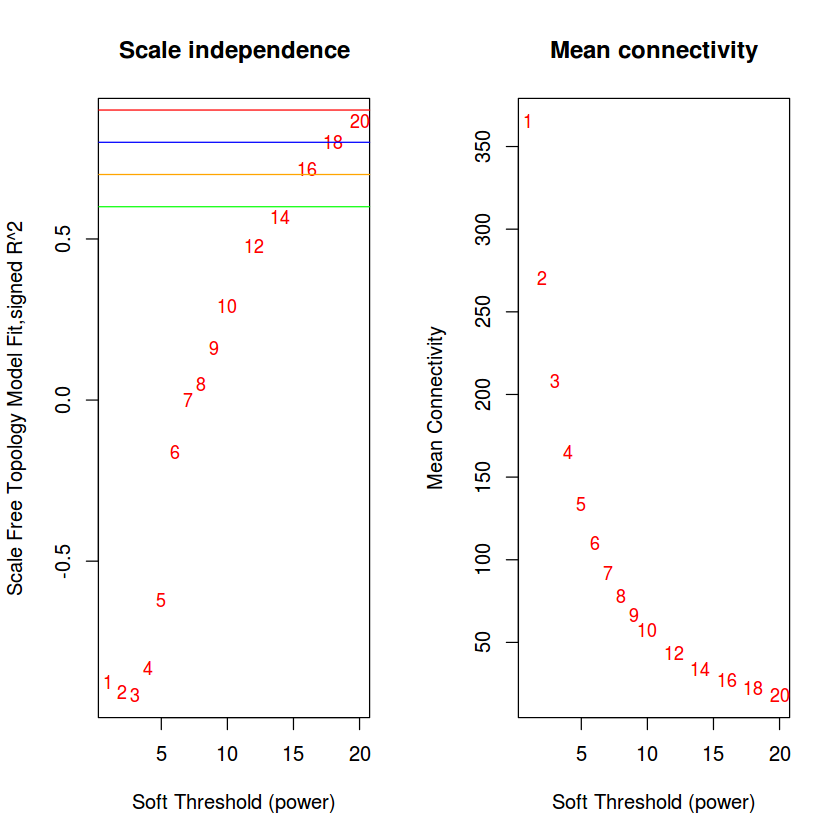

In [9]:
par(mfrow = c(1,2))
cex1 <- 0.9
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
          xlab="Soft Threshold (power)",
          ylab="Scale Free Topology Model Fit,signed R^2",type="n",
          main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
          labels=powers,cex=cex1,col="red")
# this line corresponds to using an R^2 cut-off of h
abline(h = 0.90, col = "red")
abline(h = 0.80, col = "blue")
abline(h = 0.70, col = "orange")
abline(h = 0.60, col = "green")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

Select a power based on a good scale independence and (on a lesser scale) mean connectivity.

In [10]:
power <- 20

### Constructing the TOM

In [11]:
dissTOM <- 1 - (TOMsimilarity(
    adjacency(datExpr, power = power, type = 'signed', corFnc = 'bicor'),
    TOMType = 'signed'))

..connectivity..
..matrix multiplication..
..normalization..
..done.


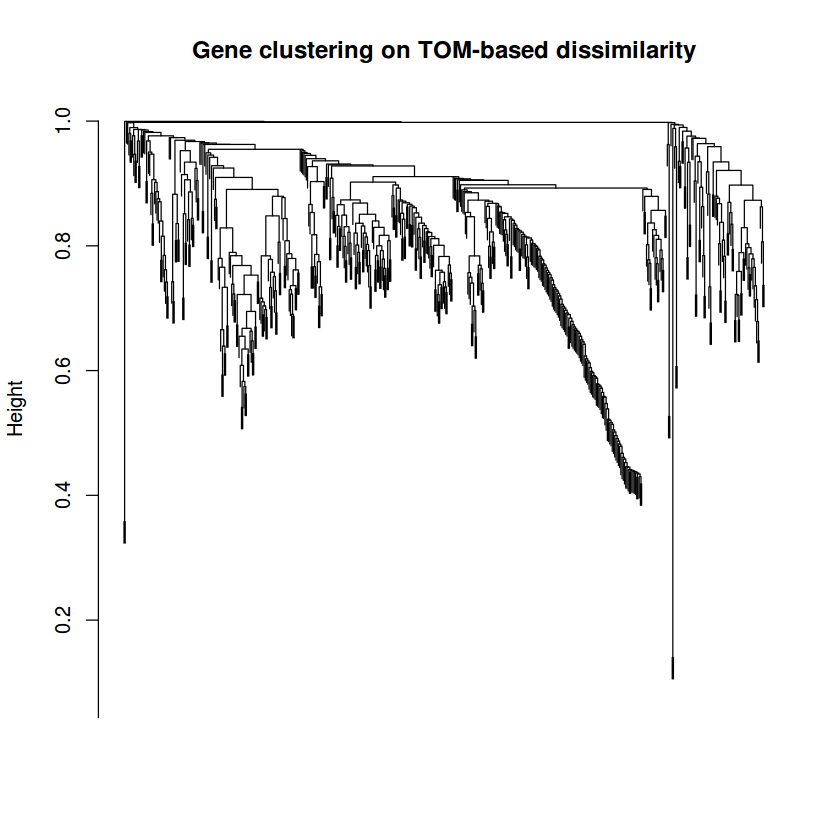

In [12]:
geneTree <- hclust(as.dist(dissTOM), method = 'average')
plot(geneTree, xlab="", sub="", 
     main = "Gene clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04)

### Creating the modules

In [13]:
minModuleSize <- 15
dynamicMods <- cutreeDynamic(dendro = geneTree, distM = dissTOM,
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = minModuleSize, verbose = 0)
table(dynamicMods)

dynamicMods
  0   1   2   3   4   5   6   7   8   9  10  11  12 
  5 146  79  59  55  37  27  23  22  20  19  17  15 

We see for each module the amount of genes it contains. Module 0 is a special module: It contains all the genes which did not fit any of the other modules. This module can be disregarded in downstream analysis.

Next we give each module its own "color" which is useful for visualization purposes. Notice that the module 0 has the color grey. This is always the case.

In [14]:
colors <- labels2colors(dynamicMods)
table(colors)

colors
      black        blue       brown       green greenyellow        grey 
         23          79          59          37          17           5 
    magenta        pink      purple         red         tan   turquoise 
         20          22          19          27          15         146 
     yellow 
         55 

Now we again plot the gene tree but this time extended with the module colors.

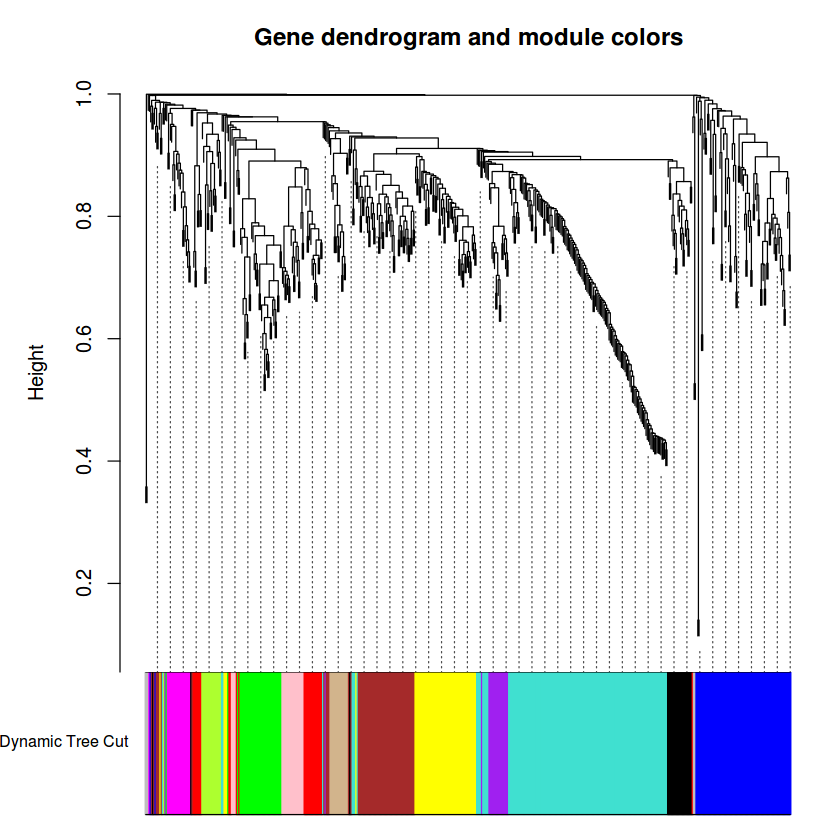

In [15]:
plotDendroAndColors(geneTree, colors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")

### Identifying interesting modules

A lot of the modules represent biological processes unrelated to the research. Therefore the next step is to find the interesting ones.

#### Module eigengenes
Here, "interesting" is defined as differential expression between sample groups. To alleviate multiple testing, we only check for a significant difference in expression using the module eigengene. This is a summarized expression profile of each module. It contains one value per sample:

In [17]:
MEs <- moduleEigengenes(datExpr, colors)$eigengenes
MEs <- orderMEs(MEs)
rownames(MEs) <- samples
MEs

,MEblue,MEgreenyellow,MEpurple,MEturquoise,MEgreen,MEpink,MEred,MEtan,MEmagenta,MEblack,MEbrown,MEyellow,MEgrey
WT_1,0.348256352,-0.11645611,-0.24732802,-0.33027397,-0.30036993,-0.37379530,-0.18191241,-0.12714875,-0.22972862,-0.20308998,-0.22601627,-0.346899874,-0.035886901
WT_2,-0.046443168,-0.27142261,-0.49981640,-0.46781282,-0.40374027,-0.43356086,-0.56909203,-0.23762672,-0.32703942,-0.33623173,-0.31276642,-0.473343639,-0.265632985
WT_3,0.213017742,-0.28223165,-0.30889679,-0.29414197,-0.37827690,-0.37825336,-0.35610868,-0.19554243,-0.10338039,-0.33215169,-0.24819729,-0.318226358,0.140048723
WT_4,0.230759859,0.12183200,-0.01733435,-0.09457881,-0.12930623,-0.10977154,-0.02817750,0.09442909,0.04667761,-0.05040782,-0.15223840,-0.221922598,0.193522570
WT_5,0.131048510,0.02896434,-0.19513579,-0.12012105,-0.25782721,-0.18626016,-0.02330787,0.11343311,0.08239335,-0.14674822,-0.13248040,-0.269767732,0.097730104
mdx_6,-0.119683228,0.15754862,0.22875207,0.04691068,0.17870660,0.01885902,0.17077418,-0.03332354,-0.06418019,0.15707574,-0.01792143,-0.007675737,-0.050056347
mdx_7,-0.216595391,-0.10329575,0.02488292,-0.11236719,0.09701438,0.13844213,0.26654793,-0.17636148,0.15235141,-0.07622825,-0.09611647,-0.011707181,0.080891119
mdx_8,-0.301927209,0.01119495,-0.10123769,-0.10575454,0.10885296,0.02231695,-0.19623045,-0.20701428,-0.31854266,-0.08862774,-0.21887915,-0.113756391,0.095028825
mdx_9,0.242288373,0.52439842,0.23512145,0.18609243,0.28843719,0.17625014,0.08166249,0.19476787,0.22370584,0.37270485,0.19061718,0.178167306,0.008550543
mdx_10,-0.194995945,0.14570426,-0.05045343,0.01744824,0.18017669,0.15772585,0.08681123,-0.23934062,-0.19900982,-0.04021645,-0.20309734,-0.041085991,0.180126559


#### Group factor
We can signify which sample belongs to which group by the use of a group factor. The row names can be used to quickly generate this factor. 

In [23]:
group <- sapply(strsplit(samples, '_'), function(x) x[[1]])
group

[1] "WT"    "WT"    "WT"    "WT"    "WT"    "mdx"   "mdx"   "mdx"   "mdx"  
[10] "mdx"   "mdx++" "mdx++" "mdx++" "mdx++" "mdx++" "mdx+-" "mdx+-" "mdx+-"
[19] "mdx+-" "mdx+-" "mdx+-"

Optional: If we don't want to differentiate between the mdx groups:

In [19]:
group <- gsub('[+-]', '', group) # Remove the character "+" and "-"
group

[1] "WT"  "WT"  "WT"  "WT"  "WT"  "mdx" "mdx" "mdx" "mdx" "mdx" "mdx" "mdx"
[13] "mdx" "mdx" "mdx" "mdx" "mdx" "mdx" "mdx" "mdx" "mdx"

In [24]:
group <- as.factor(group)

#### Kruskal-wallis test
We use the non-parametric Kruskal-wallis test to find modules with a significant change in expression between sample groups, as indicated by the group factor created above.

In [25]:
p.values <- sapply(colnames(MEs), function(col) kruskal.test(MEs[, col], group)$p.value)
p.values.adjusted <- p.adjust(p.values, 'fdr')
p.values.adjusted

MEblue MEgreenyellow      MEpurple   MEturquoise       MEgreen 
   0.12240141    0.20446126    0.07078562    0.06267037    0.03807868 
       MEpink         MEred         MEtan     MEmagenta       MEblack 
   0.03807868    0.11429354    0.36994185    0.07172003    0.04892687 
      MEbrown      MEyellow        MEgrey 
   0.02875841    0.01844684    0.45931389

Shown above is a FDR corrected p-value per module. Modules with a p-value < 0.05 are significant. 

#### Pairwise Wilcoxon tests
Now we'd like to know from which group-pairs the significance originated from, i.e. which groups are differentially expressed. To do this, we use the Wilcoxon test for each group pair for each significant module.

First create the group pairs ("combinations") we want to test for.

In [26]:
combinations <- combn(levels(group), 2)
nCombinations <- ncol(combinations)
combinations

mdx,mdx,mdx,mdx+-,mdx+-,mdx++
mdx+-,mdx++,WT,mdx++,WT,WT


Next we loop over each module. We retrieve its eigengene and p-value of the kruskal-wallis test. In case of non-significance, we simply return NA values. For significant modules, we loop through each group pair as defined in `combinations`, retrieve the eigengene values of each group, and finally run the wilcoxon test. The p-values are subsequently FDR corrected.

In [27]:
p.values.samples <- sapply(seq(1, ncol(MEs)), function(index) {
  module <- names(MEs)[index]
  eigengene <- MEs[, index]
  p.value <- p.values.adjusted[module]
  if (p.value > 0.05) { # Not significanct: skip
    return(rep(NA, nCombinations))
  }
  p.values <- apply(combinations, 2, function(combination) {
    group1_eigengene <- eigengene[which(group == combination[1])]
    group2_eigengene <- eigengene[which(group == combination[2])]
    return(wilcox.test(group1_eigengene, group2_eigengene)$p.value)
  })
  return(p.values)
})
p.values.samples <- p.adjust(unlist(as.list(p.values.samples)), 'fdr')

We had to "unlist" the p-value matrix in order to adjust the p-values, meaning we had to remove the structure (rows and columns). Now we have to restructure it:

In [28]:
p.values.samples <- t(matrix(p.values.samples, ncol=length(MEs), nrow=nCombinations))
p.values.samples <- data.frame(p.values.samples)
rownames(p.values.samples) <- names(MEs)
colnames(p.values.samples) <- apply(combinations, 2, function(c) paste(c[1], 'vs', c[2]))
p.values.samples

,mdx vs mdx+-,mdx vs mdx++,mdx vs WT,mdx+- vs mdx++,mdx+- vs WT,mdx++ vs WT
MEblue,NA,NA,NA,NA,NA,NA
MEgreenyellow,NA,NA,NA,NA,NA,NA
MEpurple,NA,NA,NA,NA,NA,NA
MEturquoise,NA,NA,NA,NA,NA,NA
MEgreen,0.5964406,0.31746032,0.02886003,0.66233766,0.02886003,0.03663004
MEpink,0.6623377,0.50476190,0.02886003,0.66233766,0.02886003,0.02886003
MEred,NA,NA,NA,NA,NA,NA
MEtan,NA,NA,NA,NA,NA,NA
MEmagenta,NA,NA,NA,NA,NA,NA
MEblack,0.4112554,0.41125541,0.05602241,0.08658009,0.18831169,0.03663004


#### Plotting the interesting modules

We have determined the interesting modules to be modules that are differentially expressed between sample groups. By plotting the module eigengenes, we expect these modules to depict a significant difference in values between the groups shown in the last table. We can now expect them visualy by plotting these values.

We start by selecting the interesting modules, i.e. modules with a p-value < 0.05 in the kruskal-wallis test.

In [29]:
modules <- names(p.values.adjusted[p.values.adjusted < 0.05])
MEs_modules <- MEs[, modules]
MEs_modules

,MEgreen,MEpink,MEblack,MEbrown,MEyellow
WT_1,-0.30036993,-0.37379530,-0.20308998,-0.22601627,-0.346899874
WT_2,-0.40374027,-0.43356086,-0.33623173,-0.31276642,-0.473343639
WT_3,-0.37827690,-0.37825336,-0.33215169,-0.24819729,-0.318226358
WT_4,-0.12930623,-0.10977154,-0.05040782,-0.15223840,-0.221922598
WT_5,-0.25782721,-0.18626016,-0.14674822,-0.13248040,-0.269767732
mdx_6,0.17870660,0.01885902,0.15707574,-0.01792143,-0.007675737
mdx_7,0.09701438,0.13844213,-0.07622825,-0.09611647,-0.011707181
mdx_8,0.10885296,0.02231695,-0.08862774,-0.21887915,-0.113756391
mdx_9,0.28843719,0.17625014,0.37270485,0.19061718,0.178167306
mdx_10,0.18017669,0.15772585,-0.04021645,-0.20309734,-0.041085991


We add some additional information and then restructure the data-frame which is useful for plotting purposes.

In [30]:
MEs_modules$group <- group
MEs_modules$mouse <- sapply(strsplit(samples, '_'), function(x) x[2])
MEs_modules$mouse <- factor(MEs_modules$mouse, levels = MEs_modules$mouse)
head(MEs_modules) # head() shows only the first couple of rows to safe space

,MEgreen,MEpink,MEblack,MEbrown,MEyellow,group,mouse
WT_1,-0.3003699,-0.37379530,-0.20308998,-0.22601627,-0.346899874,WT,1
WT_2,-0.4037403,-0.43356086,-0.33623173,-0.31276642,-0.473343639,WT,2
WT_3,-0.3782769,-0.37825336,-0.33215169,-0.24819729,-0.318226358,WT,3
WT_4,-0.1293062,-0.10977154,-0.05040782,-0.15223840,-0.221922598,WT,4
WT_5,-0.2578272,-0.18626016,-0.14674822,-0.13248040,-0.269767732,WT,5
mdx_6,0.1787066,0.01885902,0.15707574,-0.01792143,-0.007675737,mdx,6


In [31]:
library(reshape2)
melted <- melt(MEs_modules, id.vars = c('group', 'mouse'))
head(melted)

group,mouse,variable,value
WT,1,MEgreen,-0.3003699
WT,2,MEgreen,-0.4037403
WT,3,MEgreen,-0.3782769
WT,4,MEgreen,-0.1293062
WT,5,MEgreen,-0.2578272
mdx,6,MEgreen,0.1787066


We can visualize the eigengenes using a simple bar chart. Below is the code which uses the ggplot2 package to do this.


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



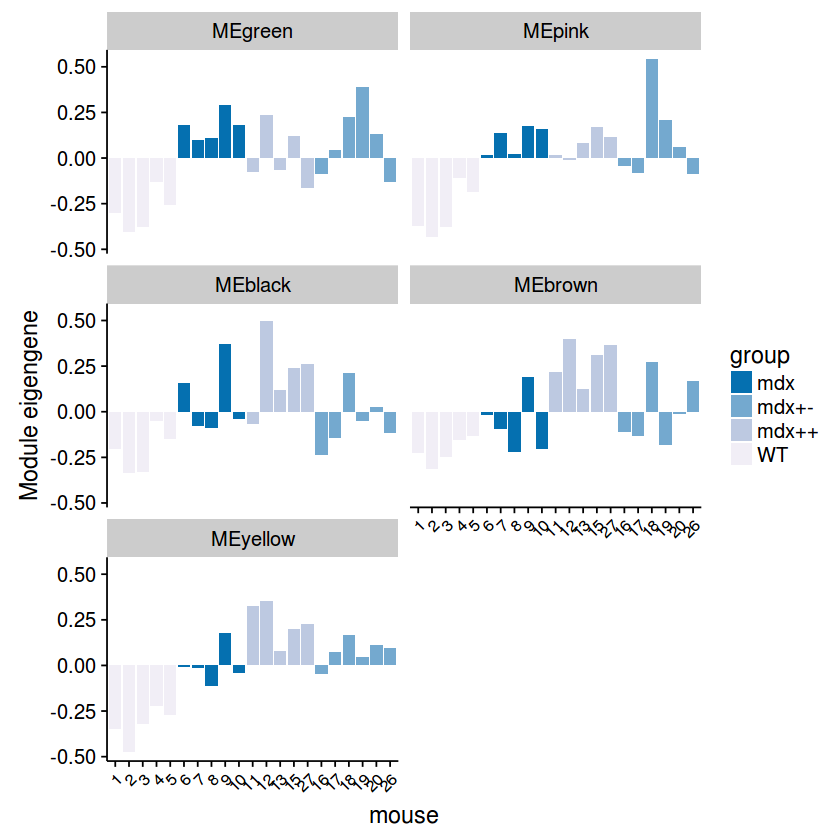

In [32]:
library(ggplot2)
library(cowplot)
ggplot(melted, aes(x = mouse, y = value, fill = group)) +
  facet_wrap(~ variable, ncol = 2) +
  geom_bar(stat = 'identity') +
  ylab('Module eigengene') + 
  scale_fill_brewer(palette="PuBu", direction = -1) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 10))